# entropy

计算 Wikipedia 与 OpenAlex Graph 熵

In [273]:
# !pip install -U python-dotenv pymongo matplotlib scipy

In [274]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from dotenv import dotenv_values
import collections
import pandas as pd
from matplotlib.ticker import FuncFormatter

env_config = dotenv_values("../.env")

# Wikipedia entropy

In [275]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["entropy"]
wikipedia_entropy_collection.count_documents({})

252

In [276]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

In [277]:
entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in wikipedia_entropy_collection.find({'entropyType':'degree', 'startPercent':0, }):
    index = doc['year'] - start_year
    if index < 0:
        continue
    endPercent = doc['endPercent']
    key = f"top {endPercent}%"
    
    entropy_data_list[key][index] = doc['entropy']['entropyin']

len(entropy_data_list)

6

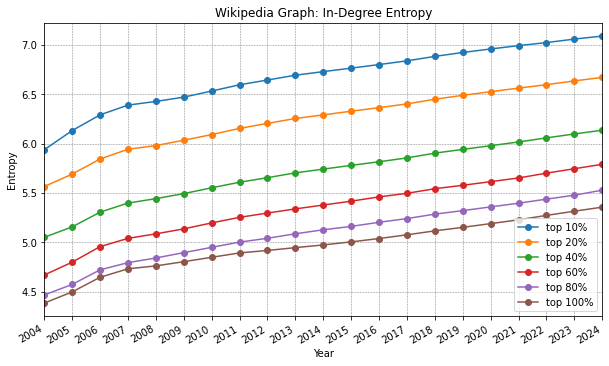

In [278]:

# plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

df = pd.DataFrame(entropy_data_list, index=year_range)
df.plot(ax=ax1, marker='o')

ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entropy')

# formatter = FuncFormatter(lambda x, pos: '{:,}'.format(int(x)))
# ax1.yaxis.set_major_formatter(formatter)

plt.title(f'Wikipedia Graph: In-Degree Entropy')
# plt.title()
ax1.legend()

plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.grid(True)
# 显示图表
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
# 添加标题和轴标签
plt.show()

In [279]:


def draw_xlsx_sheet(sheet_writer, df, sheetTitle, chartTitle,x_axis_label,
                    y_axis_label, x_axis_options={}, y_axis_options={}):
    df.to_excel(sheet_writer, sheet_name=sheetTitle, index=True)

    workbook = sheet_writer.book
    worksheet = sheet_writer.sheets[sheetTitle]

    # 获取数据范围
    num_rows, num_cols = df.shape  # 获取行数和列数
    start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
    end_row = start_row + num_rows - 1  # 数据结束行
    category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
    sales_col = 1  # 销售列（第 2 列）

    # 创建折线图
    chart = workbook.add_chart({"type": "line"})
    for col_idx, col_name in enumerate(df.columns, start=1):
        chart.add_series({
            "name":       col_name,  # 图表中的系列名称
            "categories": [sheetTitle, start_row, category_col, end_row, category_col],  # 分类轴为索引
            "values":     [sheetTitle, start_row, col_idx, end_row, col_idx],  # 值列
        })
        
    chart.set_title({"name": chartTitle})
    x_axis_options['name'] = x_axis_label
    y_axis_options['name'] = y_axis_label
    chart.set_x_axis(x_axis_options)
    chart.set_y_axis(y_axis_options)
    chart.set_size({'width': 600, 'height': 400})
    
    chart.set_legend({'position': 'right',
                      'max_width': 500,
                      'overlay': False,
                      'font': {'size': 9, 'bold': False}
                      })

    # 插入图表
    worksheet.insert_chart("F2", chart)

In [280]:
# 打开一个 xlsx 文件
XLSX_WRITER = pd.ExcelWriter('Entropy.xlsx', engine="xlsxwriter")

In [281]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "Wikipedia",
                "Wikipedia In-Degree Degree Distribution Entropy(subnet)",
                "Year",
                "Entropy", y_axis_options = {'num_format': '#,##0','min':4, 'minor_unit':1}
                )

## wikipedia subject

In [282]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["subject_entropy"]
wikipedia_entropy_collection.count_documents({})

2508

In [283]:
exception_subject = ["Art"]

entropy_map = collections.defaultdict(lambda:np.full(end_year - start_year + 1, np.nan))

for doc in wikipedia_entropy_collection.find({'level':3, 'entropyType':"degree"}):
    index = doc['year'] - start_year
    if index < 0:
        continue
    entropyin = doc['entropy']['entropyin']
    if doc['subject'] in exception_subject:
        continue
    if entropyin:
        entropy_map[doc['subject']][index] = entropyin
len(entropy_map)


18

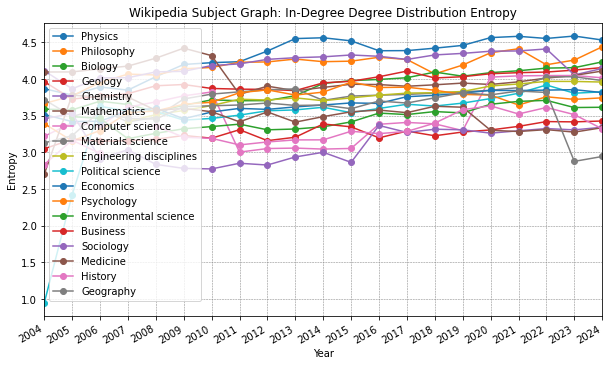

In [284]:
fig, ax1 = plt.subplots(figsize=(10, 6))

df = pd.DataFrame(entropy_map, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot(ax=ax1, marker='o')

ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entropy')

# formatter = FuncFormatter(lambda x, pos: '{:,}'.format(int(x)))
# ax1.yaxis.set_major_formatter(formatter)

plt.title(f'Wikipedia Subject Graph: In-Degree Degree Distribution Entropy')
# plt.title()
ax1.legend()

plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.grid(True)
# 显示图表
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
# 添加标题和轴标签
plt.show()

In [285]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "Wikipedia_subject",
                "Wikipedia In-Degree Degree Distribution Entropy(subject)",
                "Year",
                "Entropy",y_axis_options = {'num_format': '#,##0', 'minor_unit':1}
                )

# OpenAlex entropy

In [286]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["entropy"]
openalex_entropy_collection.count_documents({})

2040

In [287]:
start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

In [288]:
entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({'entropyType':'degree', 
                                             'rankType':'current', 
                                             'startPercent':0, }):
    index = doc['year'] - start_year
    if index < 0:
        continue
    endPercent = doc['endPercent']
    key = f"top {endPercent}%"
    
    entropy_data_list[key][index] = doc['entropy']['entropyin']

len(entropy_data_list)

6

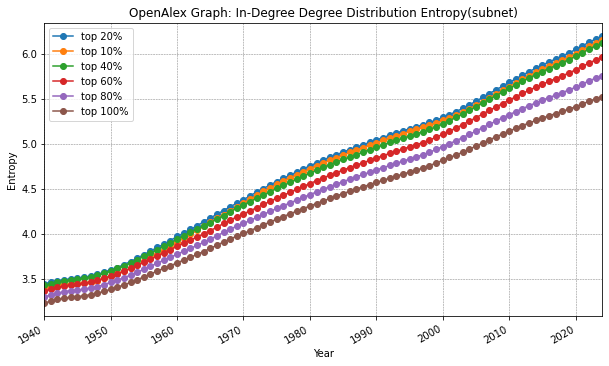

In [289]:

# plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

df = pd.DataFrame(entropy_data_list, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot(ax=ax1, marker='o')

ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entropy')

# formatter = FuncFormatter(lambda x, pos: '{:,}'.format(int(x)))
# ax1.yaxis.set_major_formatter(formatter)

plt.title(f'OpenAlex Graph: In-Degree Degree Distribution Entropy(subnet)')
# plt.title()
ax1.legend()

plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.grid(True)
# 显示图表
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
# 添加标题和轴标签
plt.show()

In [290]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex",
                "OpenAlex In-Degree Degree Distribution Entropy(subnet)",
                "Year",
                "Entropy",y_axis_options = {'num_format': '#,##0','min':3, 'minor_unit':1}
                )

## OpenAlex Subjects

In [291]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["subject_entropy"]
openalex_entropy_collection.count_documents({})

38760

In [292]:
exception_subject = []

entropy_map = collections.defaultdict(lambda:np.full(end_year - start_year + 1, np.nan))
for doc in openalex_entropy_collection.find({'entropyType':'degree', 
                                             'rankType':'current', 
                                             'endPercent':100,
                                             'startPercent':0, }):
    index = doc['year'] - start_year
    if index < 0:
        continue
    entropyin = doc['entropy']['entropyin']
    if doc['subject'] in exception_subject:
        continue
    if entropyin:
        entropy_map[doc['subject']][index] = entropyin
len(entropy_map)

19

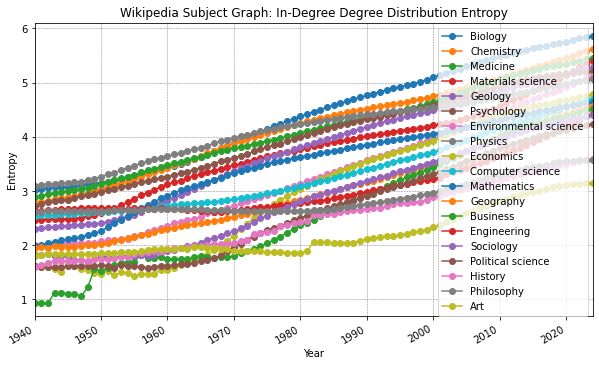

In [293]:
fig, ax1 = plt.subplots(figsize=(10, 6))

df = pd.DataFrame(entropy_map, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot(ax=ax1, marker='o')

ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entropy')

plt.title(f'Wikipedia Subject Graph: In-Degree Degree Distribution Entropy')
ax1.legend()

plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
plt.show()

In [294]:
draw_xlsx_sheet(XLSX_WRITER, 
                df, 
                "OpenAlex_subject",
                "OpenAlex In-Degree Degree Distribution Entropy(subject)",
                "Year",
                "Entropy",y_axis_options = {'num_format': '#,##0'}
                )

In [295]:
XLSX_WRITER.close()